In [43]:
from datetime import date
from dateutil.relativedelta import relativedelta
from finmarkets import DiscountCurve, CreditCurve, generate_swap_dates

T = 3 
C = 0.06
r = 0.03
R = 0.4
N = 100

obs_date = date.today()
pillars = [obs_date+relativedelta(years=i) for i in range(T+1)]
dfs = [1/(1+r)**i for i in range(T+1)]
dc = DiscountCurve(obs_date, pillars, dfs)
S = [1, 0.9, 0.8, 0.7]
cc = CreditCurve(pillars, S)

cva = 0
d = obs_date
while d <= pillars[-1]:
    cva += dc.df(d)*(cc.ndp(d) - cc.ndp(d+relativedelta(days=1)))
    d += relativedelta(days=1)

cva = cva * (1-R) * N
print ("CVA: {:.2f}".format(cva))

CVA: 17.23


In [44]:
default_free_price = 0
for i in range(1, len(pillars)):
    default_free_price += (N * ((pillars[i] - pillars[i-1]).days / 360) * 
          dc.df(pillars[i]) * C )
                    
default_free_price += N * dc.df(pillars[-1])
             
print ("Bond Price: {:.2f}".format(default_free_price - cva))

Bond Price: 91.50


In [52]:
# 460s for 1000 simulations
from datetime import date
from dateutil.relativedelta import relativedelta
from finmarkets import call_price, CreditCurve
from scipy.stats import norm
import numpy as np

np.random.seed(1)
dt = 1/365
K = 110
sigma = 0.15
mu = 0.05
r = 0.03
T = 3
R = 0.4
S = [1, 0.9, 0.8, 0.7]
obs_date = date.today()
pillars = [obs_date + relativedelta(years=i) for i in range(T+1)]
cc = CreditCurve(pillars, S)

import time
t1 = time.time()
scenarios = 1000
cvas = []

St = S0*np.ones(shape=(T*365, scenarios))    
for i in range(T*365):
    norms = norm.rvs(size=scenarios)
    St[i, :] = St[i-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma
                   * np.sqrt(dt) * norms[:])

for s in range(scenarios):
    cva = 0
    for t in range(365*T): 
        cva += call_price(dt*t, St[i, s], K, r, sigma, T)* \
                          (cc.ndp(obs_date+relativedelta(days=t))-
                           cc.ndp(obs_date+relativedelta(days=t+1)))        
    cvas.append(cva*(1-R))
        
print (np.mean(cvas))
print (time.time()-t1)

3.7521017896018973
459.46695613861084


In [114]:
T=3 
St = S0*np.ones(shape=(365*T, scenarios))    
for i in range(T*365):
    norms = norm.rvs(size=scenarios)
    St[i, :] = St[i-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma
                   * np.sqrt(dt) * norms[:])


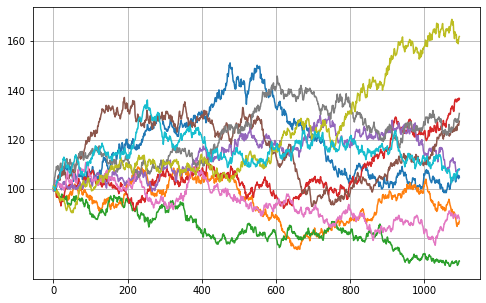

In [120]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(St[:,:10])
plt.grid(True)
plt.show()

In [53]:
# 660s for 1000 simulations
from datetime import date
from dateutil.relativedelta import relativedelta
from finmarkets import call_price, CreditCurve
from scipy.stats import norm
import numpy as np

np.random.seed(1)
dt = 1/365
K = 110
sigma = 0.15
mu = 0.05
r = 0.03
T = 3
R = 0.4
S = [1, 0.9, 0.8, 0.7]
obs_date = date.today()
pillars = [obs_date + relativedelta(years=i) for i in range(T+1)]
cc = CreditCurve(pillars, S)

import time
t1 = time.time()
scenarios = 1000
cvas = []

St = S0*np.ones(shape=(T*365, scenarios))    
for s in range(scenarios):
    cva = 0
    St = 100
    for t in range(0, 365*T): 
        St = St * np.exp((mu - 0.5 * sigma**2) * dt + sigma 
                       * np.sqrt(dt) * norm.rvs(size=1))
        cva += call_price(dt*t, St, K, r, sigma, T)*(cc.ndp(obs_date+relativedelta(days=t))-
                          cc.ndp(obs_date+relativedelta(days=t+1)))        
    cvas.append(cva*(1-R))
        
print (np.mean(cvas))
print (time.time()-t1)

2.3189955558094244
659.3864781856537


In [66]:
import pandas as pd
from scipy.stats import norm

df = pd.read_csv("historical.csv")

fox = df[df['ticker']=='FOX'].copy()
cbs = df[df['ticker']=='CBS'].copy()
abc = df[df['ticker']=='ABC'].copy()

fox['rets'] = fox['adj_close']/fox['adj_close'].shift(1) - 1 
cbs['rets'] = cbs['adj_close']/cbs['adj_close'].shift(1) - 1 
abc['rets'] = abc['adj_close']/abc['adj_close'].shift(1) - 1 

print (fox.head())

   None        date ticker  adj_close      rets
0     0  2018-03-27    FOX      36.08       NaN
1     1  2018-03-26    FOX      36.58  0.013858
2     2  2018-03-23    FOX      35.45 -0.030891
3     3  2018-03-22    FOX      36.18  0.020592
4     4  2018-03-21    FOX      36.30  0.003317


In [95]:
w = np.array([0.4, 0.35, 0.25])

rets = []
for i in range(1, len(abc)):
    ret = [fox.iloc[i]['rets'],
           abc.iloc[i]['rets'],
           cbs.iloc[i]['rets']]
    if np.NaN in ret:
        continue
    rets.append(w[0]*ret[0] + w[1]*ret[1] + w[2] * ret[2])


current_price = [fox.iloc[-1]['adj_close'], 
                 abc.iloc[-1]['adj_close'],
                 cbs.iloc[-1]['adj_close']]

portfolio_price = w.dot(current_price)

hist_var = portfolio_price*np.percentile(rets, 1)
print ('Historical VAR is {:.3f}'.format(hist_var))

Historical VAR is -1.385


In [100]:
# 460s for 1000 simulations
from datetime import date
from dateutil.relativedelta import relativedelta
from finmarkets import call_price, CreditCurve
from scipy.stats import norm
import numpy as np

np.random.seed(1)
dt = 1/365
K = 110
sigma = 0.15
mu = 0.05
r = 0.03
T = 1
R = 0.4
S = [1, 0.7]
obs_date = date.today()
pillars = [obs_date + relativedelta(years=i) for i in range(T+1)]
cc = CreditCurve(pillars, S)

scenarios = 1000
losses = []

St = S0*np.ones(shape=(T*365, scenarios))    
for i in range(T*365):
    norms = norm.rvs(size=scenarios)
    St[i, :] = St[i-1, :] * np.exp((mu - 0.5 * sigma**2) * dt + sigma
                   * np.sqrt(dt) * norms[:])

for s in range(scenarios):
    loss = 0
    for t in range(365*T): 
        loss += call_price(dt*t, St[i, s], K, r, sigma, T)* \
                          (cc.ndp(obs_date+relativedelta(days=t))-
                           cc.ndp(obs_date+relativedelta(days=t+1)))        
    losses.append(cva*(1-R))

print (np.percentile(cvas, [99.9]))

[9.96586061]
